## mDC_proportion_analysis - GSEA pipeline 
- Author: CW
- Files needed: NEBULA outputs, (mDC_proportion_analysis/2_NEBULA2_celltype_res)
- Last updated: 04/13/24
code to run GSEA analysis given a list of DEGs. converted to Rscript to run on slurm 

In [1]:
library(fgsea)
library(data.table)
library(ggplot2)

library(tibble)
library(dplyr)
#library(stringr)

library(readr)
library(tidyverse)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month

## 1. download and save canonical pathways gene sets 
https://www.gsea-msigdb.org/gsea/msigdb/download_file.jsp?filePath=/msigdb/release/2023.2.Hs/c2.cp.v2023.2.Hs.symbols.gmt

In [2]:
### load canonical pathway dataset
pathway_dir <- 'path_to_gene_set/'

In [26]:
# CP: canonical pathways
cp <- gmtPathways(paste0(pathway_dir, "c2.cp.v2023.1.Hs.symbols.gmt"))

ERROR: Error in gmtPathways(paste0(pathway_dir, "h.all.v2022.1.Hs.symbols.gmt")): could not find function "gmtPathways"


## 2. convert NEBULA objects to ranks 
convert NEBULA 1 subtype results and NEBULA 2 celltype results
- output: mDC_proportion_analysis/4_GSEA_celltype_rank_lists/ and mDC_proportion_analysis/4_GSEA_subtype_rank_lists/'

### A. by celltype 

In [26]:
celltype_res <- "./mDC_proportion_analysis/2_NEBULA2_celltype_res/"

In [36]:
save_celltype_ranks_to <- './mDC_proportion_analysis/4_GSEA_celltype_rank_lists/'

In [29]:
#column names from NEBULA2: logfc, gene.gene
for(filename in list.files(celltype_res)) {
    
    DEG_table = readRDS(paste0(celltype_res, filename))
    DEG_table = DEG_table$summary
    
    if(length(DEG_table$gene.gene) == length(DEG_table$logfc)) {
        ranks <- deframe(data.frame(gene = DEG_table$gene.gene, 
                      log2FC = DEG_table$logfc))
        saveRDS(ranks, paste0(save_celltype_ranks_to, filename))
    }
}

### B. by subtype

In [31]:
subtype_res <- './mDC_proportion_analysis/2_NEBULA_subtype_res/'

In [32]:
save_subtype_ranks_to <- './mDC_proportion_analysis/4_GSEA_subtype_rank_lists/'

In [33]:
for(filename in list.files(subtype_res)) {
    
    DEG_table = readRDS(paste0(subtype_res, filename))
    DEG_table = DEG_table$summary
    
    if(length(DEG_table$gene) == length(DEG_table$logFC_is_mDC_high1)) {
        ranks <- deframe(data.frame(gene = DEG_table$gene, 
                      log2FC = DEG_table$logFC_is_mDC_high1))
        #saveRDS(ranks, paste0(save_celltype_ranks_to, filename))
    }
}

## 3. Run GSEA 
- chose canonical pathways as final gene set 
- output: /mDC_proportion_analysis/5_GSEA_celltype_cp_res/ and /mDC_proportion_analysis/5_GSEA_subtype_cp_res/'

### A. by cell types 

In [ ]:
celltype_ranks <- './mDC_proportion_analysis/4_GSEA_celltype_rank_lists/'

In [37]:
save_cp_results <- './mDC_proportion_analysis/5_GSEA_celltype_cp_res/'

In [ ]:
for(ranks_file in list.files(celltype_ranks)) {
    
    ranks <- readRDS(paste0(celltype_ranks, ranks_file))
    cp.pathways <- fgsea(pathways=cp, stats=ranks, scoreType = 'std') 
    collapsedPathways <- collapsePathways(cp.pathways[order(pval)][padj < 0.05],
                                      cp, ranks)
    mainPathways <- cp.pathways[cp.pathways$pathway %in% collapsedPathways$mainPathways][order(-NES),pathway]
    cp.pathways$mainPathways <- cp.pathways$pathway %in% mainPathways

    #write csvs of pathways
    saveRDS(cp.pathways, paste0(save_cp_results, ranks_file)) #same names as ranks_file
    
}

   

### B. by subtypes

In [ ]:
subtype_ranks <- './mDC_proportion_analysis/4_GSEA_subtype_rank_lists/'

In [ ]:
save_cp_results <- './mDC_proportion_analysis/5_GSEA_subtype_cp_res/'

In [ ]:
for(ranks_file in list.files(subtype_ranks)) {
    
    ranks <- readRDS(paste0(subtype_ranks, ranks_file))
    cp.pathways <- fgsea(pathways=cp, stats=ranks, scoreType = 'std') 
    
    collapsedPathways <- collapsePathways(cp.pathways[order(pval)][padj < 0.05],
                                      cp, ranks)
    mainPathways <- cp.pathways[cp.pathways$pathway %in% collapsedPathways$mainPathways][order(-NES),pathway]
    cp.pathways$mainPathways <- cp.pathways$pathway %in% mainPathways

    #write csvs of pathways
    saveRDS(cp.pathways, paste0(save_cp_results, ranks_file)) #same names as ranks_file
    
}

### 4. Plot GSEA results 

Description: 
Top 3 positively and negatively enriched main pathways from GSEA results either from NEBULA2 (cell types) or NEBULA1 (subtypes) using an adjusted p-value of 0.1 The number of genes (number of genes from DEG list that are involved in the canonical pathway) are shown on a natural log scale. 

- output: 6_GSEA_celltype_cp_plots, 6_GSEA_subtype_cp_plots

In [ ]:
library(dplyr)
library(ggplot2)

### A. by celltypes - Figure 6D

In [71]:
celltypes <- c("Tumor", "CD8 T", "CD4 T", "Other T", "Cycling T", "NK", "B", "Monocyte/Macrophage", "cDC", "pDC", "Mast", 
  "Endothelial", "Fibroblast", "Keratinocyte")

In [72]:
all_tables <- data.frame(pathway = c(), celltype = c(), num_genes = c(), NES = c())

In [73]:
top_n = 3

In [74]:
celltype_cp_res_path <- './mDC_proportion_analysis/5_GSEA_celltype_cp_res/'

In [75]:
for (ct in celltypes) {
    
    filename <- gsub(" ", "_", ct)
    filename <- gsub("/", "_", filename)
    
    ct_res <- readRDS(paste0(celltype_cp_res_path,filename ,'.rds'))
    ct_res %>% filter(mainPathways == "TRUE") %>% arrange(desc(NES))
    
    #gather top positively enriched 
    positively_enriched <- ct_res %>% filter(mainPathways == "TRUE", NES > 0, padj < 0.1) %>% 
                                    arrange(padj, desc(NES)) %>% head(top_n)
    
    negatively_enriched <- ct_res %>% filter(mainPathways == "TRUE", NES < 0, padj < 0.1) %>% 
                                    arrange(padj, desc(NES)) %>% head(top_n)
    
    #celltype from file
    celltype <- strsplit(filename, '[.]')[[1]][1]
    
    if(nrow(positively_enriched) > 0) {
        summary_pos_table <- data.frame(pathway = positively_enriched$pathway, celltype = ct, num_genes = positively_enriched$size, 
                   NES = positively_enriched$NES) 
    } else {
        summary_pos_table <- data.frame(pathway = c(), celltype = c(), num_genes = c(), NES = c())
    }
    
    if(nrow(negatively_enriched) > 0) {
        summary_neg_table <- data.frame(pathway = negatively_enriched$pathway, celltype = ct, num_genes = negatively_enriched$size, 
                           NES = negatively_enriched$NES)
    } else {
        summary_neg_table <- data.frame(pathway = c(), celltype = c(), num_genes = c(), NES = c())
    }

    summary_table <- rbind(summary_pos_table, summary_neg_table)

    summary_table$pathway <- factor(x = summary_table$pathway, levels = append(summary_pos_table$pathway, summary_neg_table$pathway))
    all_tables <- rbind(all_tables, summary_table)

}
all_tables$celltype <- factor(x = all_tables$celltype, levels = rev(celltypes))

#log scale number of genes 
all_tables$ln_genes <- log(all_tables$num_genes)

In [76]:
dot_plot <- ggplot(all_tables, aes(x=pathway, y=celltype)) +
  geom_point(aes(size = ln_genes, colour = NES)) +
  scale_size("Number of genes (natural log)") + #limits(1,6)
    scale_colour_gradient2(
      low = "blue", 
      mid = "white",
      high = "red",
      midpoint = 0, 
    limits = c(-6, 6)) + #c(min(all_tables$NES), max(all_tables$NES))) + 
  #scale_fill_gradientn(colours = viridisLite::mako(100),
                      # guide = guide_colorbar(ticks.colour = "black",
                                          #    frame.colour = "black"),
                       #name = "Average\nexpression") +
  ylab("Cell type") + xlab("") +
  theme_bw() +
  theme(axis.text.x = element_text(size=8, angle=45, hjust=1, color="black"),
        axis.text.y = element_text(size=16, color="black"),
        axis.title = element_text(size=14))

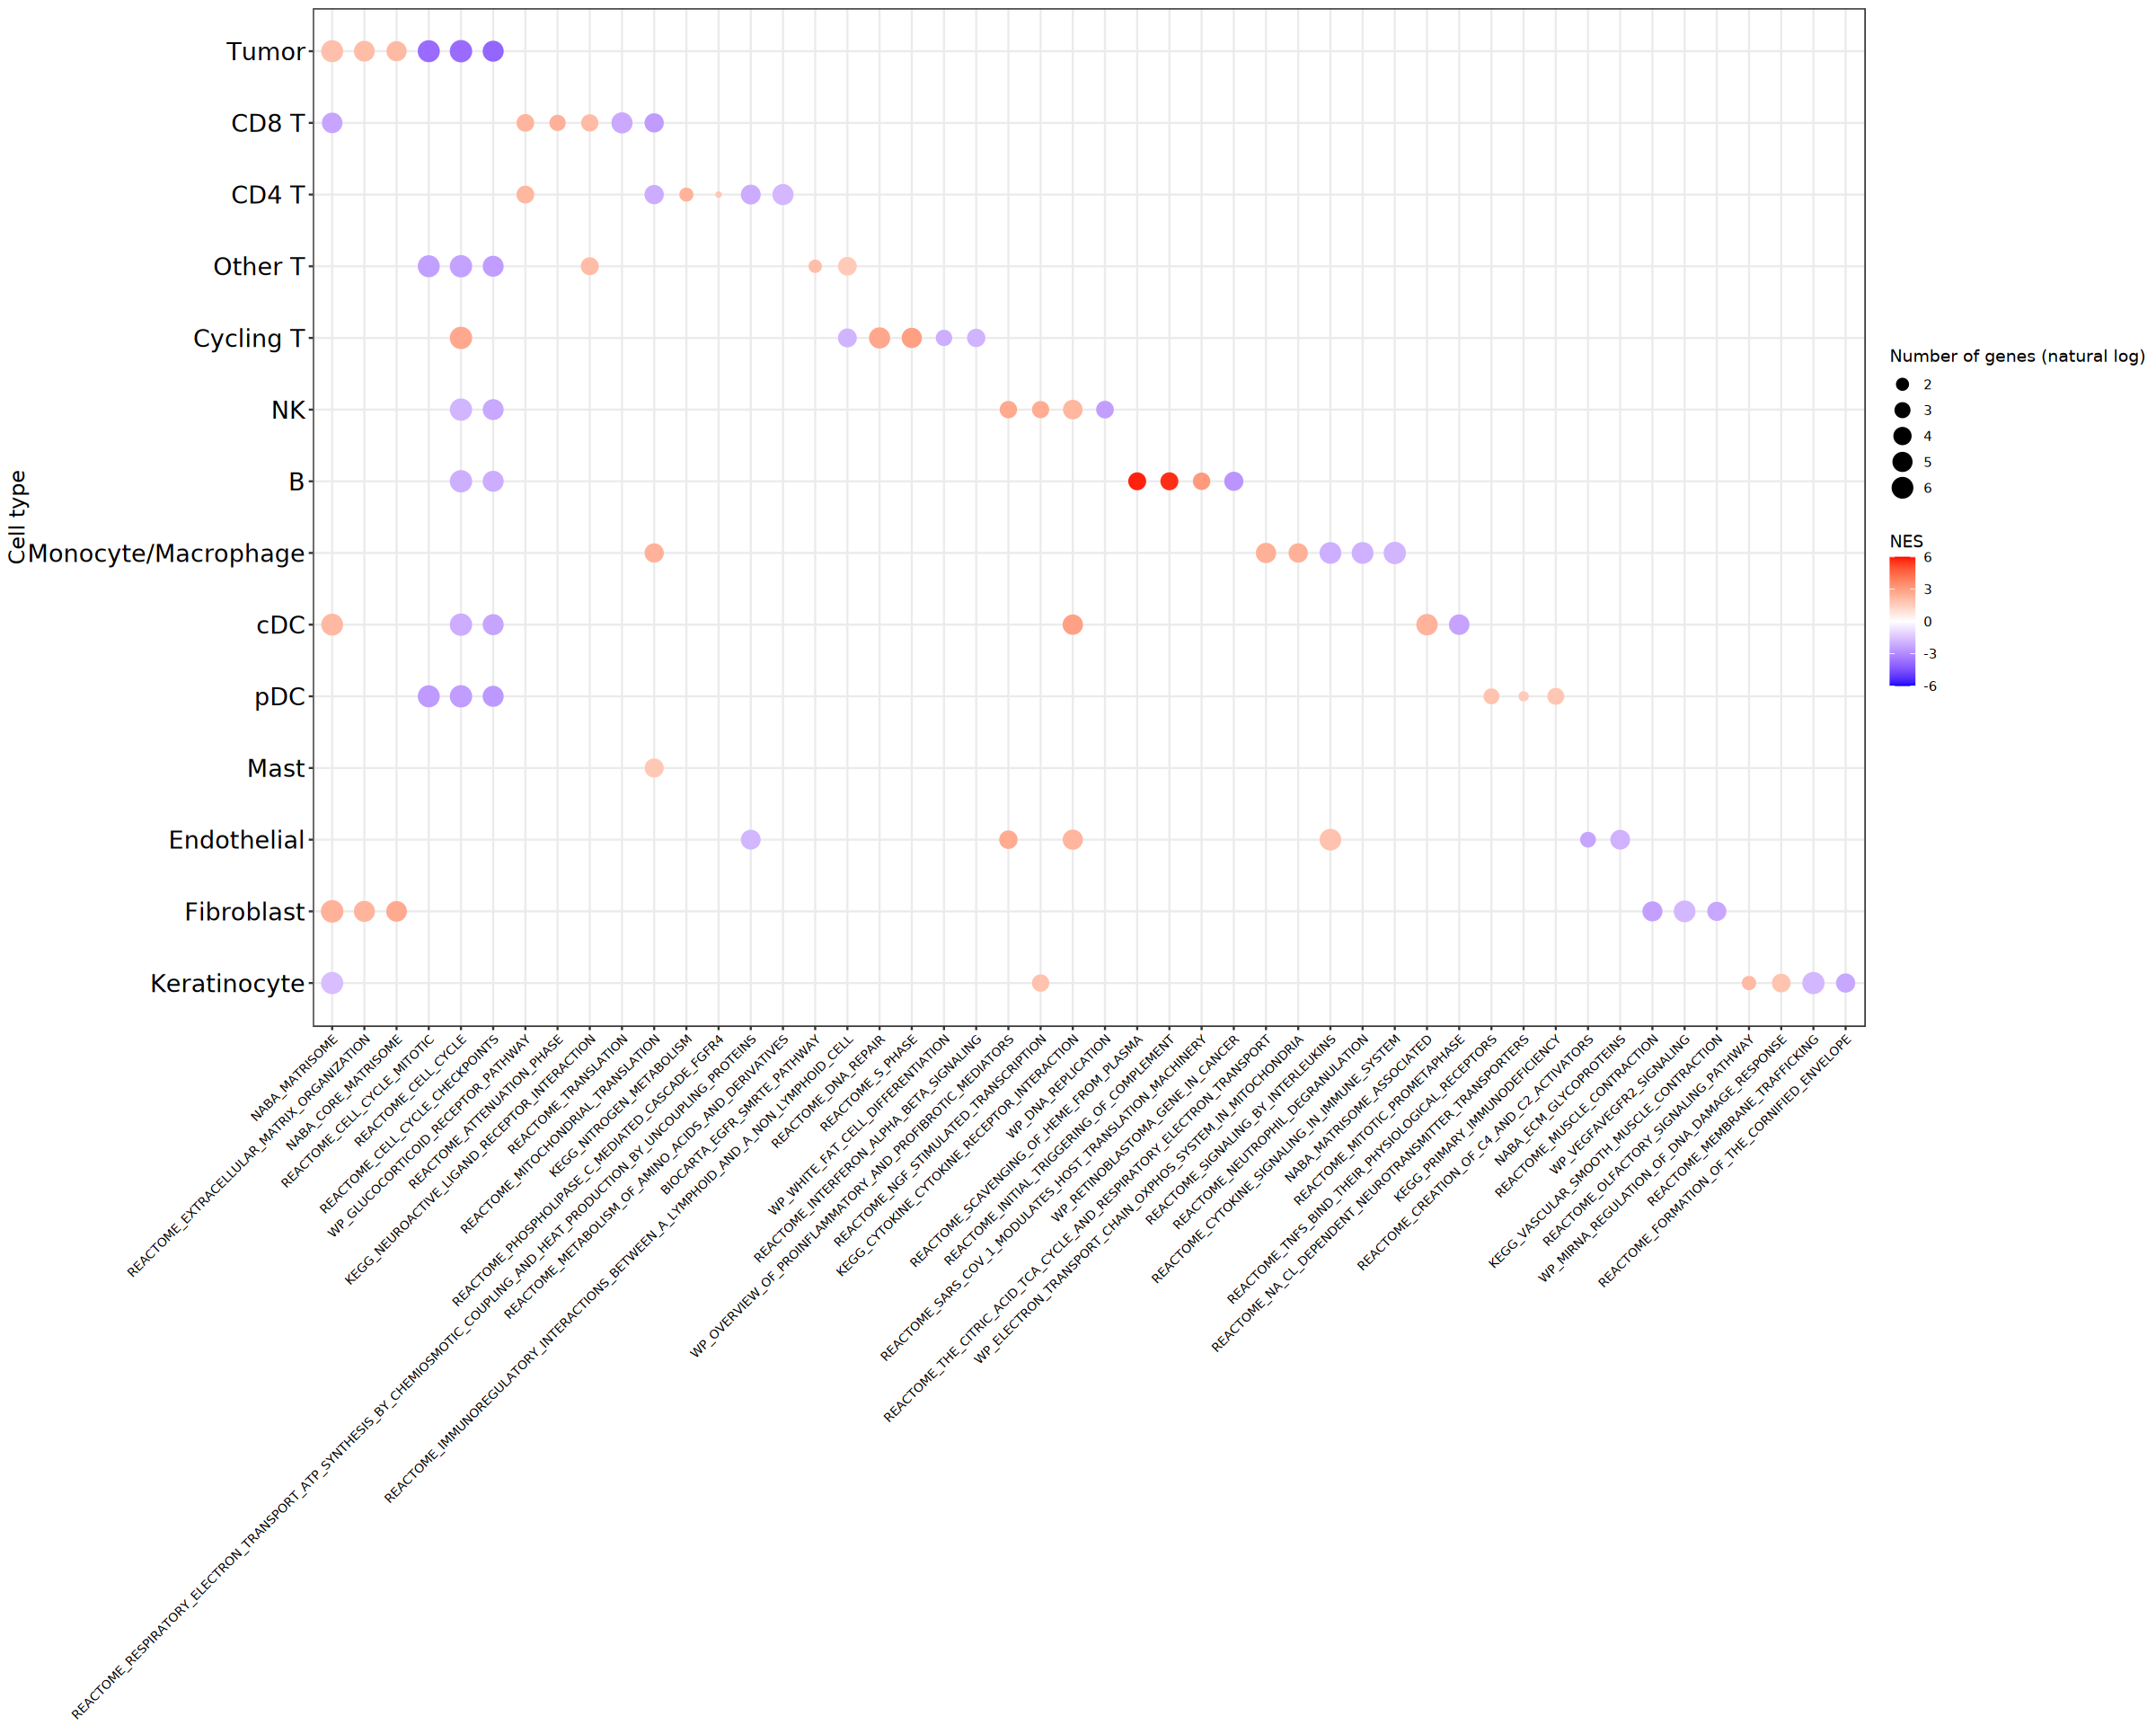

In [77]:
###Figure 6D
options(repr.plot.width = 20, repr.plot.height = 16)
dot_plot
#ggsave('./celltype_dotplot_top3_lnscale.pdf', width = 18, 
       #height = 16)

### B. by subtypes - Extended Figure 6 D-E
top 3 genes
p adjusted cutoff = 0.1

In [59]:
B <- c("Naive B", "Transitional B", "Plasma B", "Memory B")
mono_macro <- c("Monocyte classical", "Monocyte non-classical", "Macrophage M1", "Macrophage M2", "Macrophage tumor-associated") #, 
#endothelial <- c('Endothelial') #"Endothelial"
fibroblast <- c("Inflammatory fibroblast", "Myofibroblast")
Other_T <- c("DN NKT", "other T")
#pDC <- c('pDC')
#NK <- c('NK')
CD8_T <- c("CD8 Tn",  "CD8 early activated Teff", "CD8 HNRNPH1+ Teff", "CD8 GZMK+ Teff", 
           "CD8 Tem", "CD8 Texme","CD8 Tex/HS", "CD8 GNLY+ Tex", "CD8 FTL+ Tex", "CD8 NKT")
CD4_T <- c("CD4 Tn", "CD4 CD69+ T", "CD4 Tm" , "CD4 Tex", "CD4 Treg", "CD4 NKT")
Cycling_T <- c("Cycling T")
Tumor <- c("Tumor - Cell Cycle - G1/S", "Tumor - Cell Cycle - G2/M", "Tumor - Cell Cycle HMG-rich", 
           #"Tumor - EMT-III", "Tumor - Hypoxia",
           "Tumor - Interferon/MHC-II (I)", 
           #"Tumor - MYC",
           "Tumor - Protein maturation",
           "Tumor - Respiration", 
           #"Tumor - Secreted I", 
           "Tumor - Skin-pigmentation", 
           "Tumor - Stress", 
           "Tumor - Translation initiation",
           "Tumor - Unassigned",
           "Tumor - Unfolded protein response", 
           "Tumor - NA")
#Keratinocyte <- c('Keratinocyte') 
#Mast <- c("Mast")
all_celltypes_list <- list(B, mono_macro, fibroblast, Other_T, CD8_T, CD4_T,
                         Tumor) #endothelial,pDC, Cycling_T
names(all_celltypes_list) <- c('B', 'Monocyte/Macrophage',  "Fibroblast", "Other T",  
                               "CD8_T", "CD4_T", "Tumor") #"Endothelial", "pDC", "NK",

In [61]:
subtype_cp_res_path <- './mDC_proportion_analysis/5_GSEA_subtype_cp_res/'

In [54]:
top_n = 3

#### FUNCTIONS

In [66]:
subtype_GSEA_table <- function(subtype_list) {
    
    all_tables <- data.frame(pathway = c(), celltype = c(), num_genes = c(), NES = c())
    
    for (st in subtype_list) {
    
        filename <- gsub(" ", "_", st)
        filename <- gsub("/", "_", filename)
        filename <- gsub("-", "_", filename)

        st_res <- readRDS(paste0(subtype_cp_res_path,filename ,'.rds'))
        st_res %>% filter(mainPathways == "TRUE") %>% arrange(desc(NES))

        #gather top positively enriched 
        positively_enriched <- st_res %>% filter(NES > 0, padj < 0.1) %>%  #mainPathways == "TRUE"
                                        arrange(padj, desc(NES)) %>% head(top_n)

        negatively_enriched <- st_res %>% filter(NES < 0, padj < 0.1) %>%  #mainPathways == "TRUE",
                                        arrange(padj, desc(NES)) %>% head(top_n)

        #subtype from file
        subtype <- strsplit(filename, '[.]')[[1]][1]

        if(nrow(positively_enriched) > 0) {
            summary_pos_table <- data.frame(pathway = positively_enriched$pathway, subtype = st, num_genes = positively_enriched$size, 
                       NES = positively_enriched$NES) 
        } else {
            summary_pos_table <- data.frame(pathway = c(), subtype = c(), num_genes = c(), NES = c())
        }

        if(nrow(negatively_enriched) > 0) {
            summary_neg_table <- data.frame(pathway = negatively_enriched$pathway, subtype = st, num_genes = negatively_enriched$size, 
                               NES = negatively_enriched$NES)
        } else {
            summary_neg_table <- data.frame(pathway = c(), subtype = c(), num_genes = c(), NES = c())
        }

        summary_table <- rbind(summary_pos_table, summary_neg_table)

        summary_table$pathway <- factor(x = summary_table$pathway, levels = append(summary_pos_table$pathway, summary_neg_table$pathway))
        all_tables <- rbind(all_tables, summary_table)

        }

    all_tables$subtype <- factor(x = all_tables$subtype, levels = rev(subtype_list))
    return(all_tables)
    
}

In [67]:
subtype_GSEA_plot <- function(summary_table, celltype) {
    dot_plot <- ggplot(summary_table, aes(x=pathway, y=subtype)) +
                  geom_point(aes(size = ln_num_genes, colour = NES)) +
                  scale_size("number of genes (natural log)", limits = c(0,7)) +
                    scale_colour_gradient2(
                              low = "blue", 
                              mid = "white",
                              high = "red",
                              midpoint = 0, 
                                limits = c(-6, 6)) + 
  #scale_fill_gradientn(colours = viridisLite::mako(100),
                      # guide = guide_colorbar(ticks.colour = "black",
                                          #    frame.colour = "black"),
                       #name = "Average\nexpression") +
  ylab("subtype") + xlab("") +
  theme_bw() +
  theme(axis.text.x = element_text(size=10, angle=45, hjust=1, color="black"),
        axis.text.y = element_text(size=12, color="black"),
        axis.title = element_text(size=14)) + ggtitle(paste0('Top canonical pathways for ', 
                                                   celltype, ' cell subtypes'))
    
    return(dot_plot)
    
}

In [52]:
### EXTENDED FIGURE 6D-E Fibroblast and Tumor 

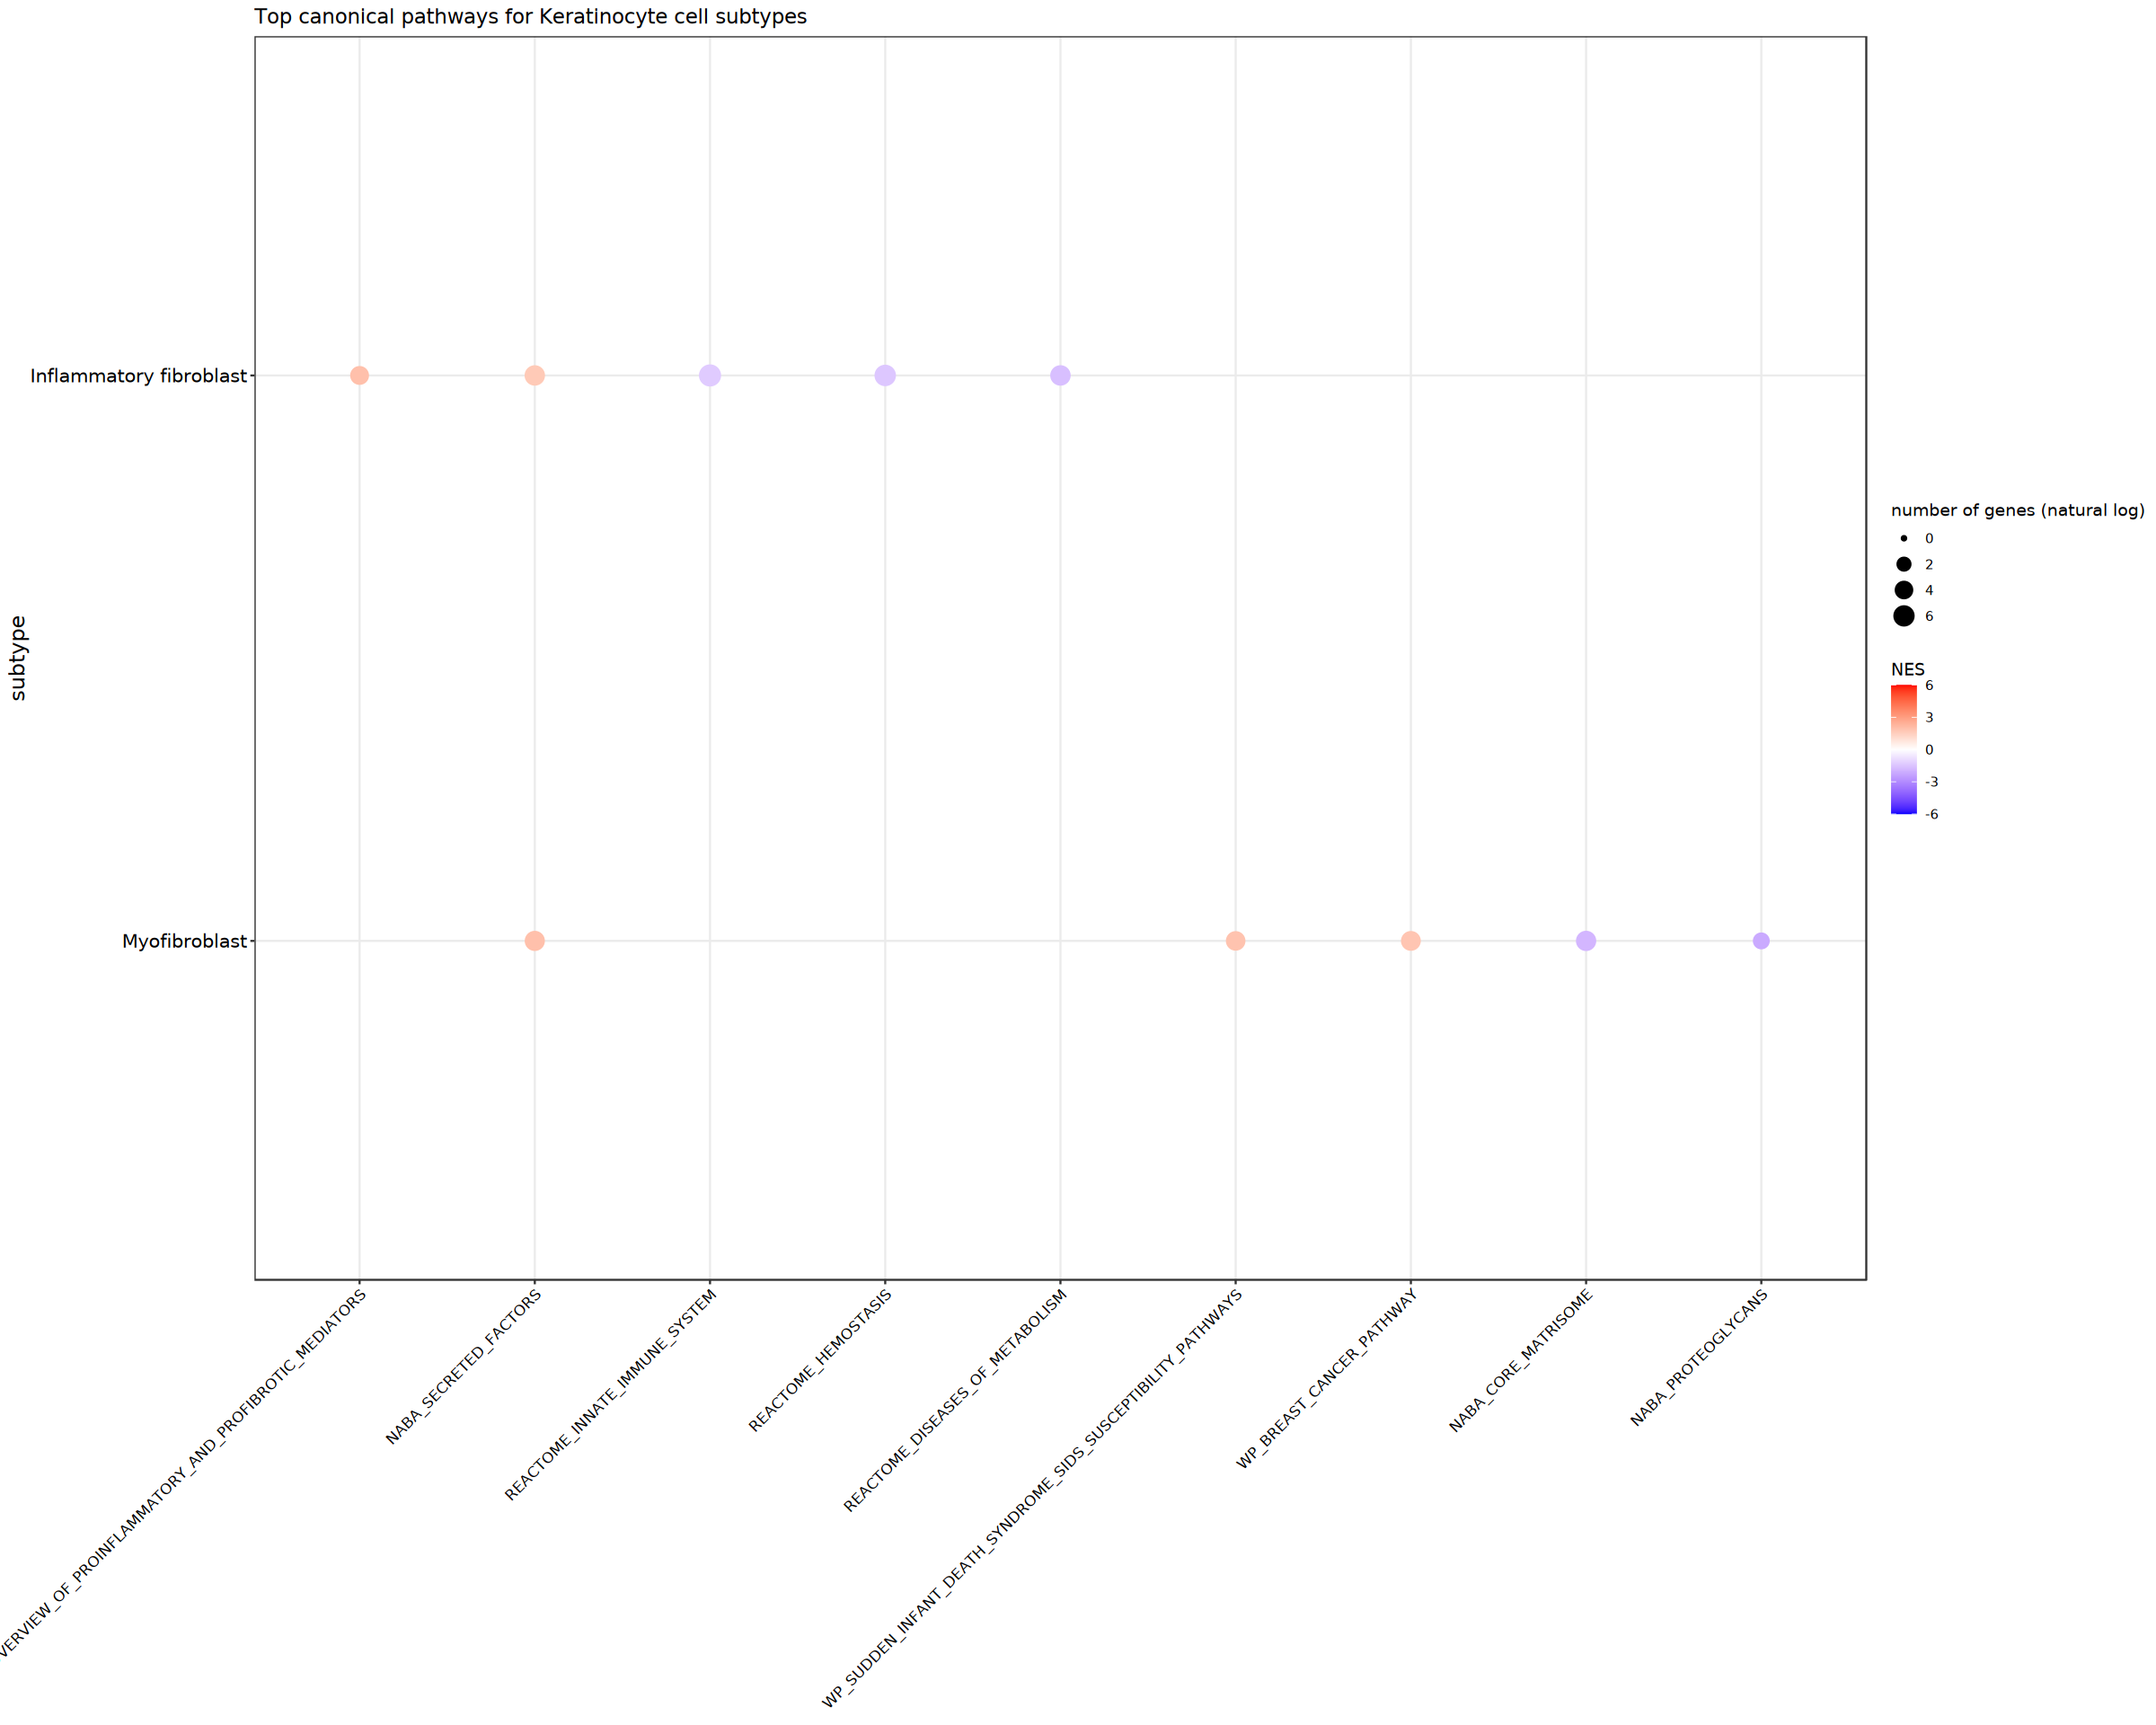

In [82]:
summary_table <- subtype_GSEA_table(all_celltypes_list[['Fibroblast']])

summary_table$ln_num_genes <- log(summary_table$num_genes)
plot <- subtype_GSEA_plot(summary_table, celltype)

filename <- gsub(" ", "_", celltype)
filename <- gsub("/", "_", filename)
filename <- gsub("-", "_", filename)
plot

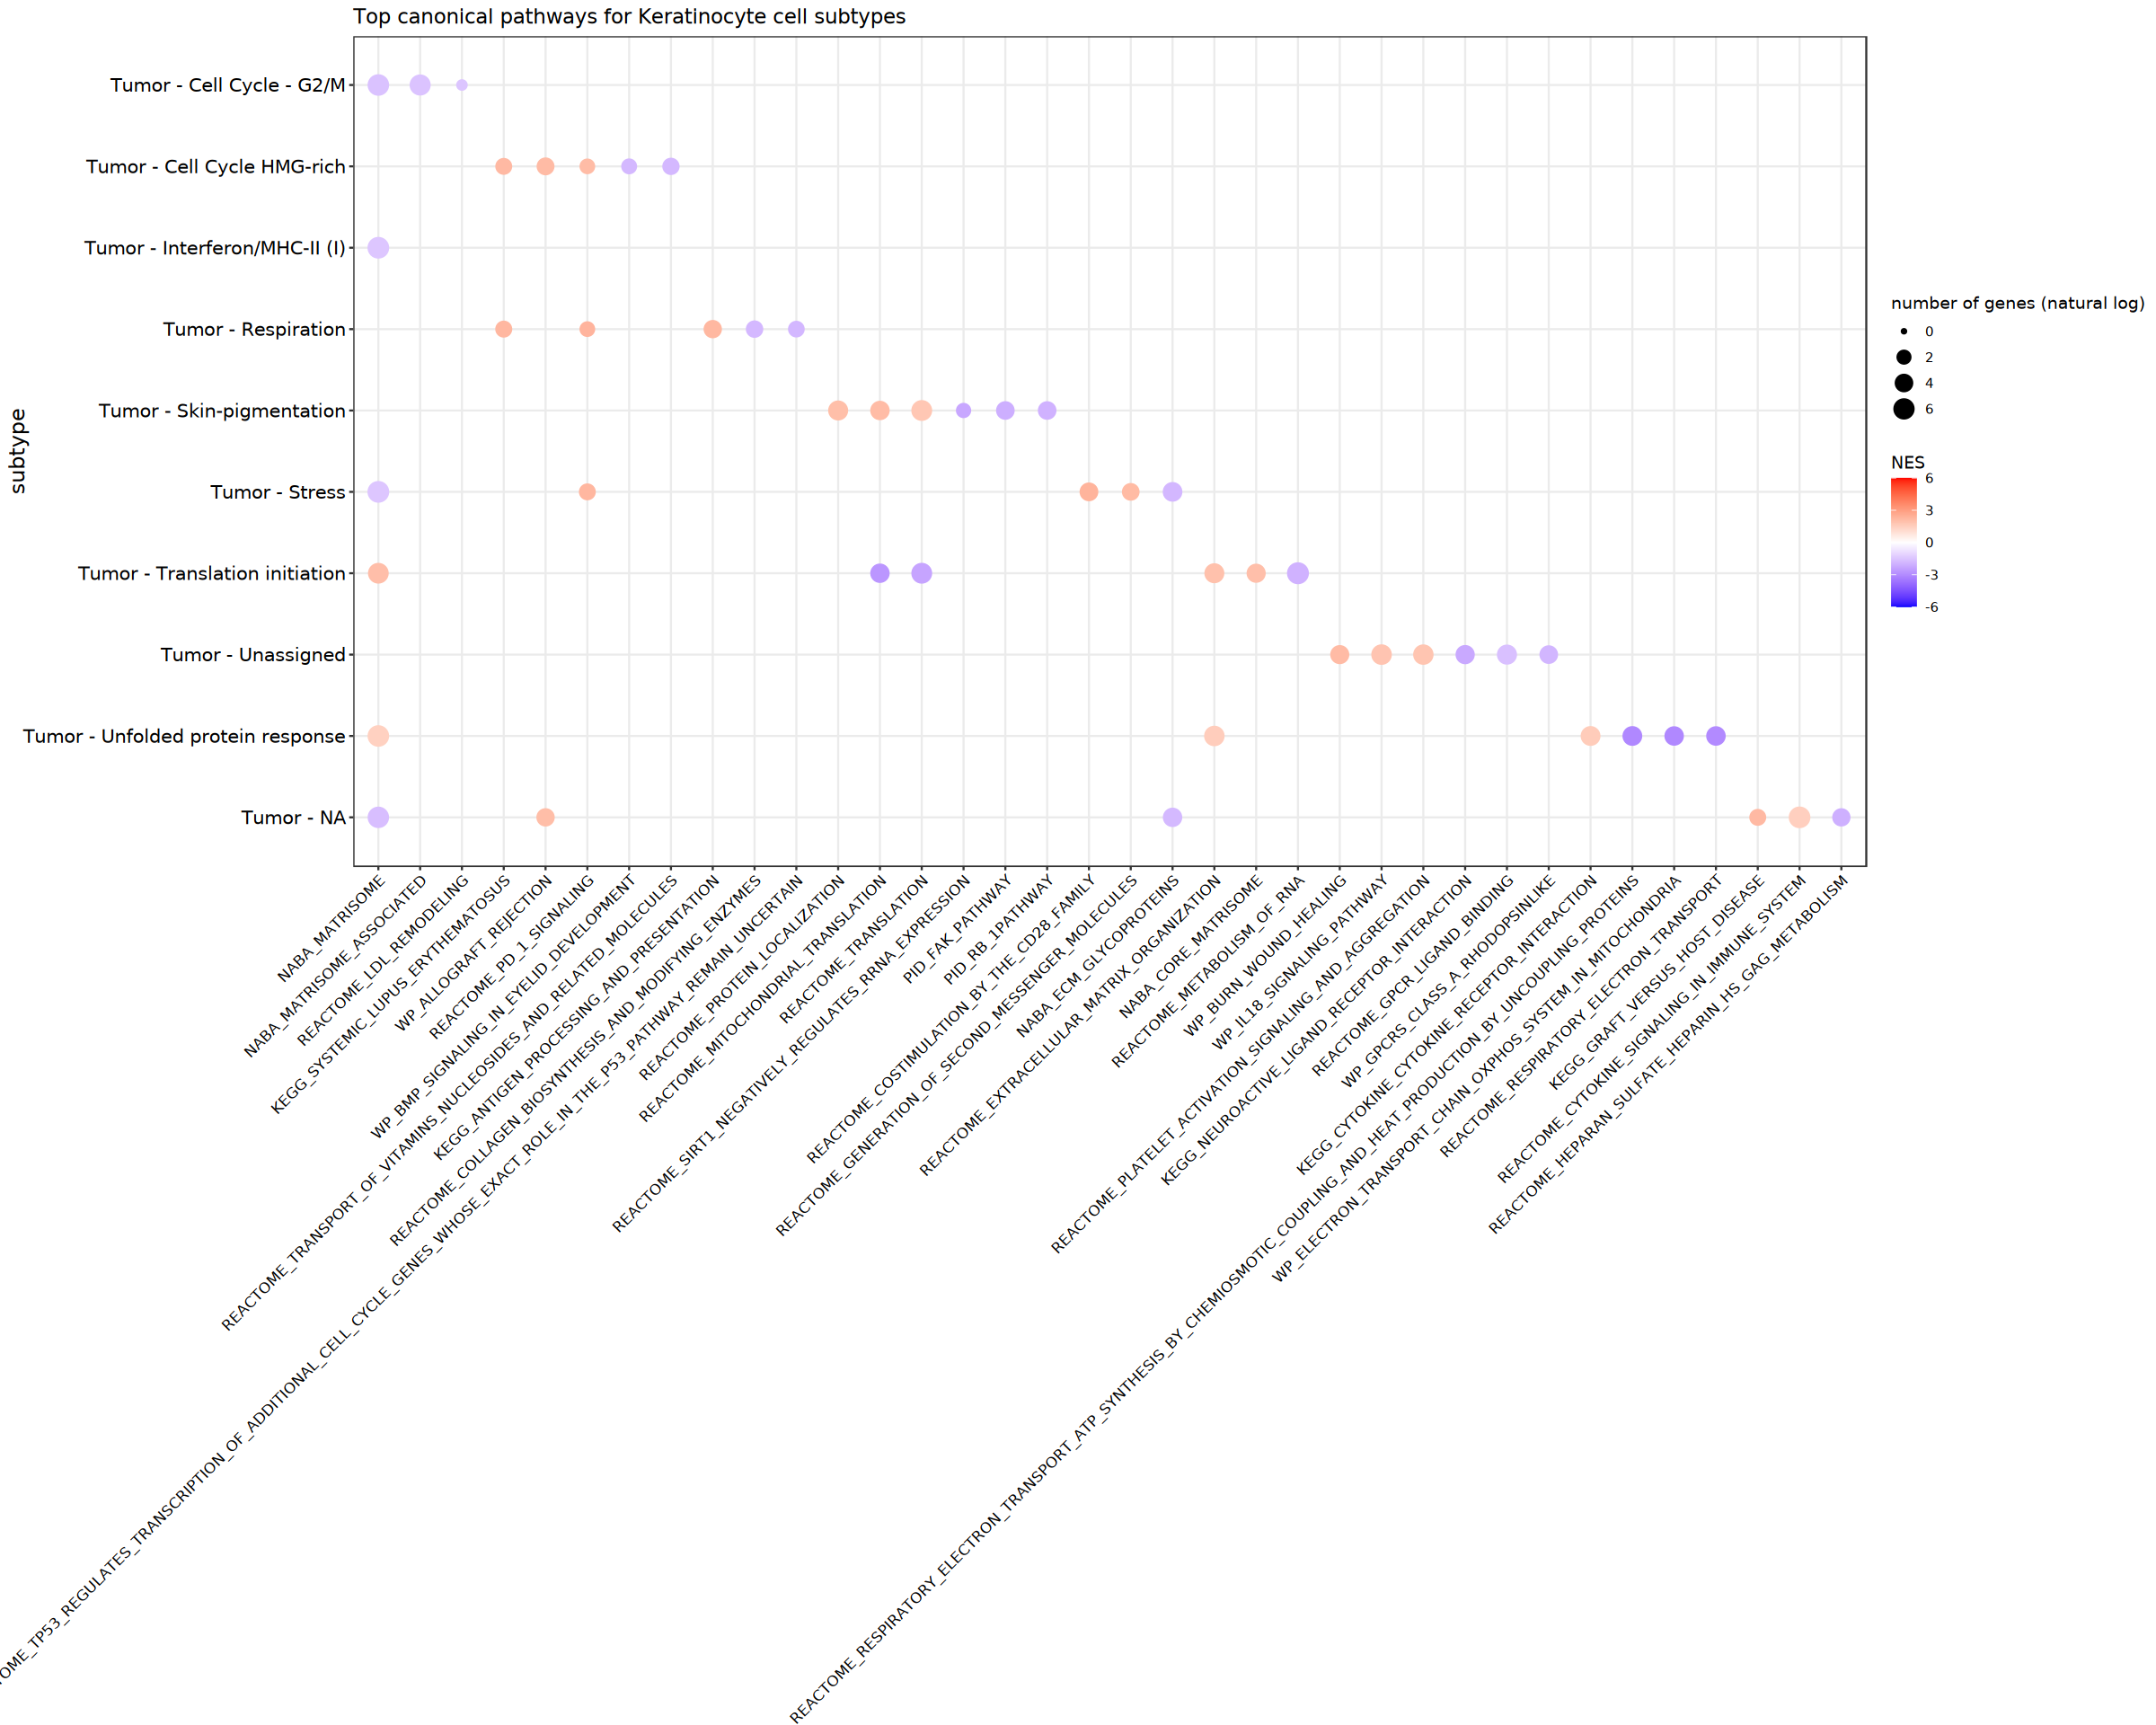

In [83]:
summary_table <- subtype_GSEA_table(all_celltypes_list[['Tumor']])

summary_table$ln_num_genes <- log(summary_table$num_genes)
plot <- subtype_GSEA_plot(summary_table, celltype)

filename <- gsub(" ", "_", celltype)
filename <- gsub("/", "_", filename)
filename <- gsub("-", "_", filename)
plot